In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [49]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [50]:
class DNN_1(nn.Module):
    def __init__(self, input_dim,dropout_rate):
        super(DNN_1, self).__init__()
        self.layer1 = nn.Linear(input_dim,64)
        self.layer2 = nn.Linear(64,32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 8)
        self.output_layer = nn.Linear(8, 1)

        self.dropout = nn.Dropout(dropout_rate)
        
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)

        x = torch.relu(self.layer3(x))
        x = self.dropout(x)

        x = torch.relu(self.layer4(x))
        x = self.dropout(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [51]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

Optunaの設定

In [52]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    dropout_rate = trial.suggest_float("dropout_rate", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   

    # モデルの定義
    model = DNN_1(
        input_dim=X_train_tensor.shape[1],
        dropout_rate=dropout_rate
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >0.49).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaのプルーニング機能
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  


最適化

In [53]:
device_id = 0  
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-04 16:03:11,754] A new study created in memory with name: no-name-5b10d9ad-22dc-484f-8b4c-8ef16e1058fd
/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:05:44,706] Trial 0 finished with value: 0.0 and parameters: {'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00032120320541404634, 'weight_decay': 0.040581928751169755}. Best is trial 0 with value: 0.0.


Early stopping at epoch 46
Final MCC: 0.0000


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:06:40,352] Trial 1 finished with value: 0.0 and parameters: {'dropout_rate': 0.4, 'learning_rate': 0.01065448907548243, 'weight_decay': 3.539803209845973e-05}. Best is trial 0 with value: 0.0.


Early stopping at epoch 16
Final MCC: 0.0000


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:07:15,682] Trial 2 finished with value: 0.0 and parameters: {'dropout_rate': 0.1, 'learning_rate': 0.013628823798296177, 'weight_decay': 5.500913475344659e-05}. Best is trial 0 with value: 0.0.


Early stopping at epoch 10
Final MCC: 0.0000


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:07:48,435] Trial 3 finished with value: 0.0 and parameters: {'dropout_rate': 0.1, 'learning_rate': 0.0281431485798467, 'weight_decay': 0.0031393123422925606}. Best is trial 0 with value: 0.0.


Early stopping at epoch 10
Final MCC: 0.0000


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:08:23,078] Trial 4 finished with value: 0.0 and parameters: {'dropout_rate': 0.05, 'learning_rate': 0.022022677128034743, 'weight_decay': 0.08516688913232084}. Best is trial 0 with value: 0.0.


Early stopping at epoch 12
Final MCC: 0.0000


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:08:26,218] Trial 5 pruned. 
[I 2024-12-04 16:08:29,132] Trial 6 pruned. 
[I 2024-12-04 16:08:32,206] Trial 7 pruned. 
[I 2024-12-04 16:08:35,672] Trial 8 pruned. 
[I 2024-12-04 16:09:24,873] Trial 9 finished with value: 0.0 and parameters: {'dropout_rate': 0.0, 'learning_rate': 0.013935295943983485, 'weight_decay': 0.040382443534843986}. Best is trial 0

Early stopping at epoch 16
Final MCC: 0.0000


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:09:31,248] Trial 10 pruned. 
[I 2024-12-04 16:09:34,153] Trial 11 pruned. 
[I 2024-12-04 16:09:37,268] Trial 12 pruned. 
[I 2024-12-04 16:10:19,930] Trial 13 finished with value: -0.07142857142857142 and parameters: {'dropout_rate': 0.45, 'learning_rate': 0.09743975129780719, 'weight_decay': 0.00023424092372742125}. Best is trial 0 with value: 0.0.


Early stopping at epoch 13
Final MCC: -0.0714


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:10:23,020] Trial 14 pruned. 
[I 2024-12-04 16:10:26,301] Trial 15 pruned. 
[I 2024-12-04 16:10:32,262] Trial 16 pruned. 
[I 2024-12-04 16:10:38,135] Trial 17 pruned. 
[I 2024-12-04 16:10:40,539] Trial 18 pruned. 
[I 2024-12-04 16:10:43,585] Trial 19 pruned. 
[I 2024-12-04 16:10:46,708] Trial 20 pruned. 
[I 2024-12-04 16:10:49,740] Trial 21 pruned. 
[I 2

Early stopping at epoch 16
Final MCC: 0.0000


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:12:10,616] Trial 29 pruned. 
[I 2024-12-04 16:12:13,677] Trial 30 pruned. 
[I 2024-12-04 16:12:54,303] Trial 31 finished with value: 0.0 and parameters: {'dropout_rate': 0.05, 'learning_rate': 0.02747417033094975, 'weight_decay': 0.036925276110843744}. Best is trial 0 with value: 0.0.


Early stopping at epoch 12
Final MCC: 0.0000


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:12:57,499] Trial 32 pruned. 
[I 2024-12-04 16:13:40,391] Trial 33 finished with value: 0.0 and parameters: {'dropout_rate': 0.15000000000000002, 'learning_rate': 0.07097956241828236, 'weight_decay': 0.002076487434659302}. Best is trial 0 with value: 0.0.


Early stopping at epoch 13
Final MCC: 0.0000


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:13:43,176] Trial 34 pruned. 
[I 2024-12-04 16:15:25,002] Trial 35 finished with value: 0.0 and parameters: {'dropout_rate': 0.1, 'learning_rate': 0.0012126547682390738, 'weight_decay': 0.057811431291089004}. Best is trial 0 with value: 0.0.


Early stopping at epoch 32
Final MCC: 0.0000


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:15:28,037] Trial 36 pruned. 
[I 2024-12-04 16:15:30,788] Trial 37 pruned. 
[I 2024-12-04 16:15:33,972] Trial 38 pruned. 
[I 2024-12-04 16:15:36,899] Trial 39 pruned. 
[I 2024-12-04 16:15:39,884] Trial 40 pruned. 
[I 2024-12-04 16:15:42,980] Trial 41 pruned. 
[I 2024-12-04 16:15:45,990] Trial 42 pruned. 
[I 2024-12-04 16:15:48,816] Trial 43 pruned. 
[I 2

Early stopping at epoch 39
Final MCC: 0.0000


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:18:06,622] Trial 48 pruned. 
[I 2024-12-04 16:21:34,658] Trial 49 finished with value: 0.23960336183731895 and parameters: {'dropout_rate': 0.1, 'learning_rate': 0.00010807010455172024, 'weight_decay': 0.001365000713070354}. Best is trial 49 with value: 0.23960336183731895.


Early stopping at epoch 58
Final MCC: 0.2396


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:21:38,124] Trial 50 pruned. 
[I 2024-12-04 16:21:41,596] Trial 51 pruned. 
[I 2024-12-04 16:21:45,040] Trial 52 pruned. 
[I 2024-12-04 16:21:48,495] Trial 53 pruned. 
[I 2024-12-04 16:21:52,000] Trial 54 pruned. 
[I 2024-12-04 16:21:55,478] Trial 55 pruned. 
[I 2024-12-04 16:21:58,780] Trial 56 pruned. 
[I 2024-12-04 16:25:13,107] Trial 57 finished with

Early stopping at epoch 54
Final MCC: 0.2905


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:25:16,834] Trial 58 pruned. 
[I 2024-12-04 16:25:20,877] Trial 59 pruned. 
[I 2024-12-04 16:25:24,721] Trial 60 pruned. 
[I 2024-12-04 16:28:51,537] Trial 61 finished with value: 0.28822639439987935 and parameters: {'dropout_rate': 0.35000000000000003, 'learning_rate': 0.00010130953272835106, 'weight_decay': 6.121577021058211e-05}. Best is trial 57 with

Early stopping at epoch 57
Final MCC: 0.2882


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:28:55,352] Trial 62 pruned. 
[I 2024-12-04 16:31:35,307] Trial 63 finished with value: 0.3238620405592368 and parameters: {'dropout_rate': 0.4, 'learning_rate': 0.00010336013884046553, 'weight_decay': 1.541972005167913e-05}. Best is trial 63 with value: 0.3238620405592368.


Early stopping at epoch 43
Final MCC: 0.3239


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:31:38,971] Trial 64 pruned. 
[I 2024-12-04 16:31:42,673] Trial 65 pruned. 
[I 2024-12-04 16:31:46,437] Trial 66 pruned. 
[I 2024-12-04 16:33:29,826] Trial 67 finished with value: 0.33186358504663327 and parameters: {'dropout_rate': 0.35000000000000003, 'learning_rate': 0.0002177616093605527, 'weight_decay': 0.0001647271314588826}. Best is trial 67 with 

Early stopping at epoch 27
Final MCC: 0.3319


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:33:33,601] Trial 68 pruned. 
[I 2024-12-04 16:33:37,278] Trial 69 pruned. 
[I 2024-12-04 16:33:41,050] Trial 70 pruned. 
[I 2024-12-04 16:33:44,901] Trial 71 pruned. 
[I 2024-12-04 16:38:06,275] Trial 72 finished with value: 0.3238620405592368 and parameters: {'dropout_rate': 0.35000000000000003, 'learning_rate': 0.00010106004460718199, 'weight_decay': 

Early stopping at epoch 67
Final MCC: 0.3239


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:38:10,201] Trial 73 pruned. 
[I 2024-12-04 16:38:14,336] Trial 74 pruned. 
[I 2024-12-04 16:42:27,190] Trial 75 finished with value: 0.3295017884191656 and parameters: {'dropout_rate': 0.45, 'learning_rate': 0.00013678173737581822, 'weight_decay': 0.0001410316372163552}. Best is trial 67 with value: 0.33186358504663327.


Early stopping at epoch 65
Final MCC: 0.3295


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:45:46,257] Trial 76 finished with value: 0.0 and parameters: {'dropout_rate': 0.45, 'learning_rate': 0.00013725076519172512, 'weight_decay': 0.00012531582112467469}. Best is trial 67 with value: 0.33186358504663327.


Early stopping at epoch 51
Final MCC: 0.0000


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:45:50,118] Trial 77 pruned. 
[I 2024-12-04 16:50:13,129] Trial 78 finished with value: 0.2533301124386585 and parameters: {'dropout_rate': 0.25, 'learning_rate': 0.00012991528481279057, 'weight_decay': 3.0731919348304456e-05}. Best is trial 67 with value: 0.33186358504663327.


Early stopping at epoch 68
Final MCC: 0.2533


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:50:16,986] Trial 79 pruned. 
[I 2024-12-04 16:53:28,685] Trial 80 finished with value: 0.29817371283399563 and parameters: {'dropout_rate': 0.45, 'learning_rate': 0.00015926115031850434, 'weight_decay': 6.5763654287087e-05}. Best is trial 67 with value: 0.33186358504663327.


Early stopping at epoch 48
Final MCC: 0.2982


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:53:32,600] Trial 81 pruned. 
[I 2024-12-04 16:57:32,850] Trial 82 finished with value: 0.29068518436261376 and parameters: {'dropout_rate': 0.45, 'learning_rate': 0.0001485924577067095, 'weight_decay': 9.890274620074636e-05}. Best is trial 67 with value: 0.33186358504663327.


Early stopping at epoch 61
Final MCC: 0.2907


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 16:57:36,762] Trial 83 pruned. 
[I 2024-12-04 16:57:40,609] Trial 84 pruned. 
[I 2024-12-04 16:57:44,464] Trial 85 pruned. 
[I 2024-12-04 16:57:48,363] Trial 86 pruned. 
[I 2024-12-04 16:57:52,341] Trial 87 pruned. 
[I 2024-12-04 16:57:56,370] Trial 88 pruned. 
[I 2024-12-04 16:58:00,541] Trial 89 pruned. 
[I 2024-12-04 16:58:04,687] Trial 90 pruned. 
[I 2

Early stopping at epoch 43
Final MCC: 0.3296


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:01:02,153] Trial 93 pruned. 
[I 2024-12-04 17:01:06,228] Trial 94 pruned. 
[I 2024-12-04 17:01:10,258] Trial 95 pruned. 
[I 2024-12-04 17:06:20,413] Trial 96 finished with value: 0.14450601225429946 and parameters: {'dropout_rate': 0.4, 'learning_rate': 0.00011946147243436633, 'weight_decay': 3.127320812055098e-05}. Best is trial 67 with value: 0.331863

Early stopping at epoch 78
Final MCC: 0.1445


/tmp/ipykernel_181066/812690434.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_181066/812690434.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-04 17:06:24,375] Trial 97 pruned. 
[I 2024-12-04 17:06:28,486] Trial 98 pruned. 
[I 2024-12-04 17:06:32,468] Trial 99 pruned. 


Best Parameters:  {'dropout_rate': 0.35000000000000003, 'learning_rate': 0.0002177616093605527, 'weight_decay': 0.0001647271314588826}
Best Validation F1:  0.33186358504663327


In [2]:
best_params = study.best_params

# JSON形式で保存
with open("../../optim_param/optim_DNN_1_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

NameError: name 'study' is not defined

最適化パラメーターで再学習

Epoch [1/100], Loss: 0.7125
Epoch [1/100], Train Loss: 0.7125, Val Loss: 0.6920
Epoch [2/100], Loss: 0.6556
Epoch [2/100], Train Loss: 0.6556, Val Loss: 0.6027
Epoch [3/100], Loss: 0.6157
Epoch [3/100], Train Loss: 0.6157, Val Loss: 0.5841
Epoch [4/100], Loss: 0.6064
Epoch [4/100], Train Loss: 0.6064, Val Loss: 0.5816
Epoch [5/100], Loss: 0.5975
Epoch [5/100], Train Loss: 0.5975, Val Loss: 0.5764
Epoch [6/100], Loss: 0.5929
Epoch [6/100], Train Loss: 0.5929, Val Loss: 0.5758
Epoch [7/100], Loss: 0.5868
Epoch [7/100], Train Loss: 0.5868, Val Loss: 0.5734
Epoch [8/100], Loss: 0.5868
Epoch [8/100], Train Loss: 0.5868, Val Loss: 0.5725
Epoch [9/100], Loss: 0.5779
Epoch [9/100], Train Loss: 0.5779, Val Loss: 0.5730
Epoch [10/100], Loss: 0.5784
Epoch [10/100], Train Loss: 0.5784, Val Loss: 0.5702
Epoch [11/100], Loss: 0.5778
Epoch [11/100], Train Loss: 0.5778, Val Loss: 0.5697
Epoch [12/100], Loss: 0.5719
Epoch [12/100], Train Loss: 0.5719, Val Loss: 0.5682
Epoch [13/100], Loss: 0.5715
Epoch

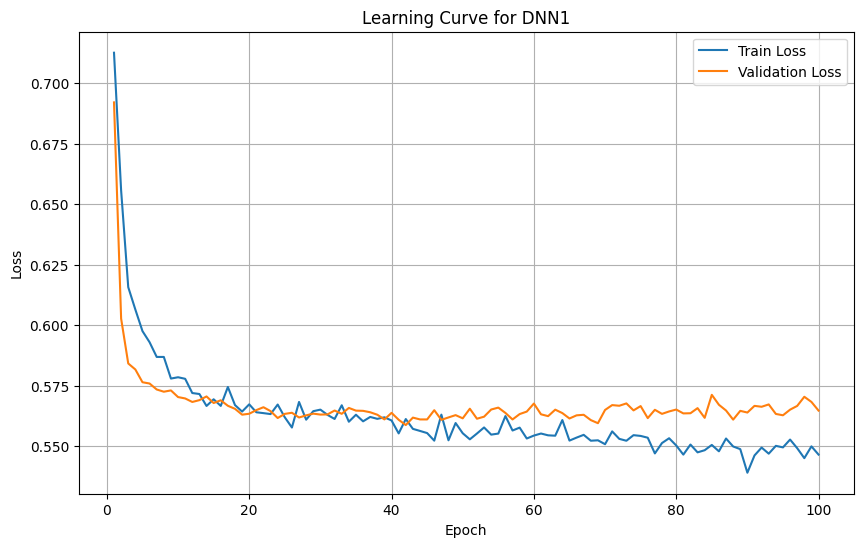

In [54]:
best_params=study.best_params
model = DNN_1(input_dim=X_train_tensor.shape[1],dropout_rate=best_params["dropout_rate"]).to(device)

# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 57.74%
Precision: 0.4624
Recall: 0.5811
F1 Score: 0.5150
Matthews Correlation Coefficient: 0.1522
Specificity: 0.5751


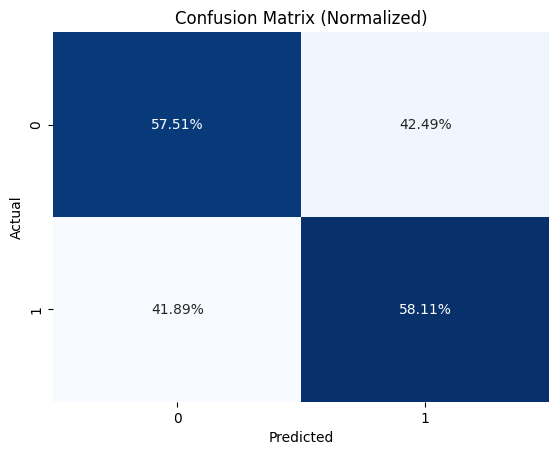

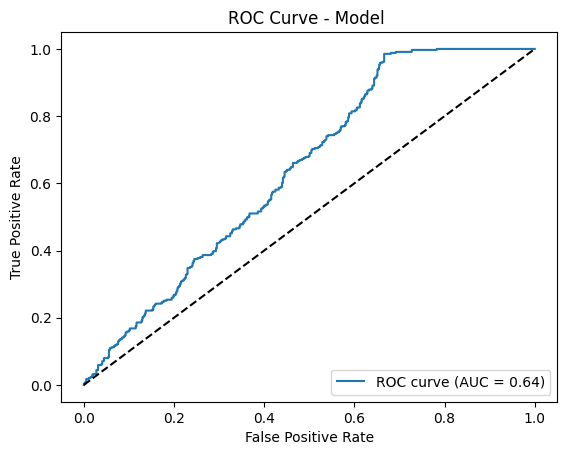

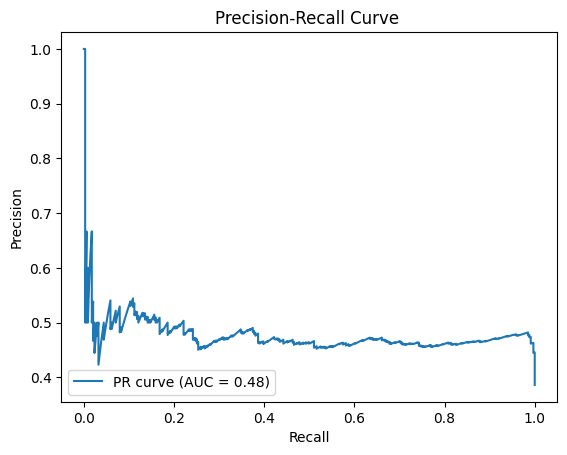

In [55]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [56]:
# モデルと構造を保存
torch.save(model.state_dict(), '../../saved_model/DNN_1.pth')
